In [31]:
# import matplotlib.pyplot as plt
# import numpy as np
# import matplotlib as mpl

# mpl.rc('font', family='serif', serif='cmr10')
# plt.rcParams['axes.unicode_minus'] = False

# # Enable LaTeX rendering
# plt.rcParams['text.usetex'] = True
# plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath, amssymb} \usepackage{newtxtext, newtxmath}'

# # Ajustar el tamaño de fuente globalmente
# plt.rcParams.update({'font.size': 14})

In [78]:
import matplotlib.pyplot as plt
from matplotlib import font_manager

font_path = 'Gulliver.otf'  # Your font path goes here
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)

plt.rcParams['font.family'] = 'Gulliver'
plt.rcParams['font.sans-serif'] = prop.get_name()
import matplotlib.pyplot as plt

plt.rcParams.update({
    "font.size": 10,  # Tamanho de fonte recomendado para artigos científicos (8-12 pt)
    "axes.labelsize": 10,  # Tamanho dos rótulos dos eixos
    "axes.titlesize": 10,  # Tamanho do título
    "xtick.labelsize": 10,  # Tamanho dos ticks do eixo X
    "ytick.labelsize": 10,  # Tamanho dos ticks do eixo Y
    "legend.fontsize": 10,  # Tamanho da legenda
})

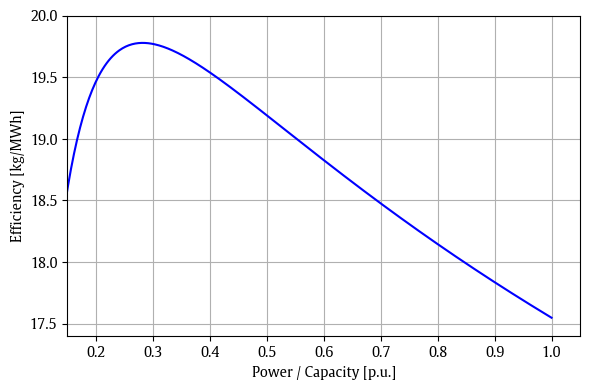

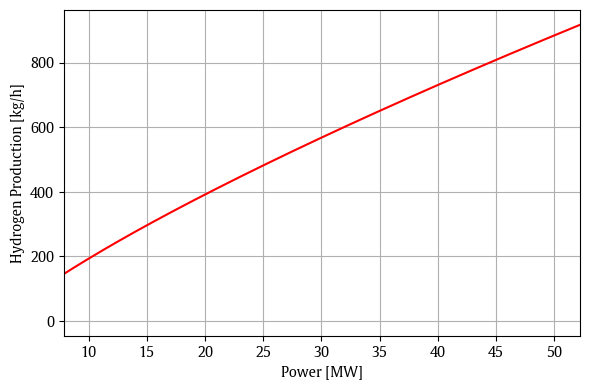

In [79]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

#mpl.rc('font', family='serif', serif='cmr10', size=10)
#plt.rcParams['axes.unicode_minus'] = False

# Constants
a1, a2, a3, a4 = 1.5184, 1.5421E-03, 9.523E-05, 9.84E-08  # Reversible voltage coefficients
r1, r2 = 4.45153E-05, 6.88874E-09  # Ohmic resistance coefficients
d1, d2 = -3.12996E-06, 4.47137E-07  # Pressure dependency coefficients
s, t1, t2, t3 = 0.33824, -0.01539, 2.00181, 15.24178  # Activation overpotential parameters
f11, f12, f21, f22 = 478645.74, -2953.15, 1.0396, -0.00104  # Faraday efficiency parameters
F_const = 96485.3321  # Faraday constant in C/mol
M_H2 = 2.0159  # Molar mass of hydrogen (kg/kmol)
HHV = 39.41  # Higher Heating Value of Hydrogen (MWh/kg)
T_cell = 90  # Cell temperature in Celsius
p_cell = 30  # Cell pressure in bar
A_cell = 0.2  # Electrode area (m²)
C_E = 104.5 / 2  # Electrolyzer capacity (MW)
i_max = 5000  # Maximum current density (A/m²)

# Define range for Current Density (i)
i = np.linspace(1, i_max, 500)  # Avoid zero to prevent log issues

# Functions
def U_rev(T):
    """Computes reversible cell voltage."""
    T_K = T + 273.15
    return a1 - a2 * T_K + a3 * T_K * np.log(T_K) + a4 * T_K**2

def U_cell(T, p, i):
    """Computes real cell voltage."""
    return U_rev(T) + ((r1 + d1) + r2 * T + d2 * p) * i + s * np.log10((t1 + t2 / T + t3 / T**2) * i + 1)

def P_cell(T, p, i):
    """Computes cell power consumption."""
    return i * U_cell(T, p, i)

def eta_F(T, i):
    """Computes Faraday efficiency."""
    return (i**2 / (f11 + f12 * T + i**2)) * (f21 + f22 * T)

def H2_production(T, i, A, n_c):
    """Computes hydrogen production rate (kg/h)."""
    return (eta_F(T, i) * n_c * M_H2 * i * A) / (2 * F_const) * 3.6  # Convert from kg/s to kg/h

def eta_kg_per_MWh(T, i, A, n_c):
    """Computes efficiency in kg/MWh."""
    P_elec = P_cell(T, p_cell, i) * A * n_c / 1e6  # Convert W to MW
    return H2_production(T, i, A, n_c) / P_elec  # kg/MWh

def n_cell(i_max, A_cell, C_E, T, p):
    """Computes the number of cells needed."""
    I_max_cell = i_max * A_cell
    U_max_cell = U_cell(T, p, i_max)
    P_max_cell = I_max_cell * U_max_cell
    return (C_E * 1e6) / P_max_cell  # Number of cells

# Compute values
n_c = n_cell(i_max, A_cell, C_E, T_cell, p_cell)  # Number of cells
P_elec = P_cell(T_cell, p_cell, i) * A_cell * n_c / 1e6  # Power in MW
H2_prod_kg_h = H2_production(T_cell, i, A_cell, n_c)  # H2 Production (kg/h)
efficiency_kg_per_MWh = eta_kg_per_MWh(T_cell, i, A_cell, n_c)  # Efficiency in kg/MWh

# Convert Power to p.u.
P_base = np.max(P_elec)  # Define base power as maximum power in the dataset
P_elec_pu = P_elec / P_base  # Convert power to per unit (p.u.)

# Remove NaN or infinite values (for low power cases)
efficiency_kg_per_MWh = np.nan_to_num(efficiency_kg_per_MWh, nan=0, posinf=0, neginf=0)

# Plot Efficiency in kg/MWh vs. Electric Power (p.u.)
plt.figure(figsize=(6, 4))
plt.plot(P_elec_pu, efficiency_kg_per_MWh, color='b')
plt.xlabel("Power / Capacity [p.u.]")
plt.ylabel("Efficiency [kg/MWh]")
plt.xlim(0.15,1.05)
plt.ylim(17.4,20)
plt.grid()
plt.tight_layout()
plt.savefig('Efficiency_curve.pdf', bbox_inches='tight', pad_inches=0.02)

# Plot Hydrogen Production (kg/h) vs. Electric Power (p.u.)
plt.figure(figsize=(6, 4))
plt.plot(P_elec, H2_prod_kg_h, color='r')
plt.xlabel("Power [MW]")
plt.ylabel("Hydrogen Production [kg/h]")
plt.xlim(0.15*P_base,P_base)
plt.grid()
plt.tight_layout()
plt.savefig('Hydrogen_production.pdf', bbox_inches='tight', pad_inches=0.02)
plt.show()

Segment 0: Interval [0.15000, 0.20967], A = 21.95515, B = -0.50413
Segment 1: Interval [0.20967, 0.28030], A = 20.45748, B = -0.19011
Segment 2: Interval [0.28030, 0.36366], A = 19.20255, B = 0.16165
Segment 3: Interval [0.36366, 0.46270], A = 18.14480, B = 0.54631
Segment 4: Interval [0.46270, 0.57649], A = 17.23039, B = 0.96940
Segment 5: Interval [0.57649, 0.70381], A = 16.42897, B = 1.43142
Segment 6: Interval [0.70381, 0.84550], A = 15.71121, B = 1.93658
Segment 7: Interval [0.84550, 1.00000], A = 15.05862, B = 2.48835


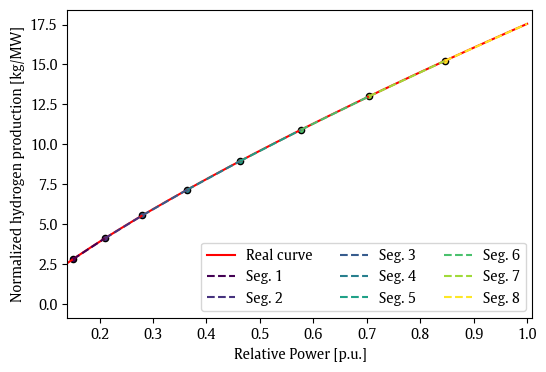

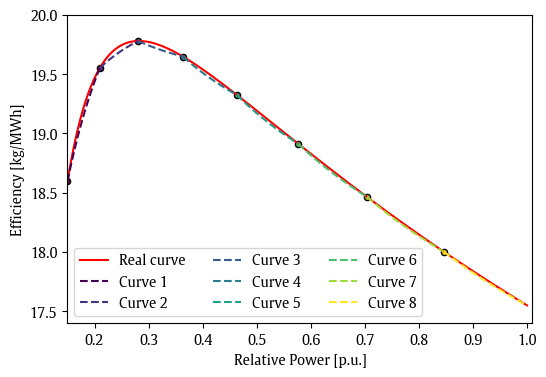

In [80]:
import numpy as np
import matplotlib.pyplot as plt

# Constants and parameters (same as before)
a1, a2, a3, a4 = 1.5184, 1.5421E-03, 9.523E-05, 9.84E-08
r1, r2 = 4.45153E-05, 6.88874E-09
d1, d2 = -3.12996E-06, 4.47137E-07
s, t1, t2, t3 = 0.33824, -0.01539, 2.00181, 15.24178
f11, f12, f21, f22 = 478645.74, -2953.15, 1.0396, -0.00104
F_const = 96485.3321
M_H2 = 2.0159
HHV = 39.41
T_cell = 90
p_cell = 30
A_cell = 0.2
C_E = 104.5 / 2
i_max = 5000

# Current density vector (avoid zero to prevent log issues)
i = np.linspace(1, i_max, 500)

# Functions from the model
def U_rev(T):
    T_K = T + 273.15
    return a1 - a2 * T_K + a3 * T_K * np.log(T_K) + a4 * T_K**2

def U_cell(T, p, i):
    return U_rev(T) + ((r1 + d1) + r2 * T + d2 * p) * i + s * np.log10((t1 + t2 / T + t3 / T**2) * i + 1)

def P_cell(T, p, i):
    return i * U_cell(T, p, i)

def eta_F(T, i):
    return (i**2 / (f11 + f12 * T + i**2)) * (f21 + f22 * T)

def H2_production(T, i, A, n_c):
    return (eta_F(T, i) * n_c * M_H2 * i * A) / (2 * F_const) * 3.6  # kg/h

def eta_kg_per_MWh(T, i, A, n_c):
    P_elec = P_cell(T, p_cell, i) * A * n_c / 1e6  # MW
    return H2_production(T, i, A, n_c) / P_elec  # kg/MWh

def n_cell(i_max, A_cell, C_E, T, p):
    I_max_cell = i_max * A_cell
    U_max_cell = U_cell(T, p, i_max)
    P_max_cell = I_max_cell * U_max_cell
    return (C_E * 1e6) / P_max_cell

# Generate the master curve from the cell-level model:
n_c = n_cell(i_max, A_cell, C_E, T_cell, p_cell)
P_elec = P_cell(T_cell, p_cell, i) * A_cell * n_c / 1e6  # MW (master curve)
H2_prod = H2_production(T_cell, i, A_cell, n_c)            # kg/h
efficiency = eta_kg_per_MWh(T_cell, i, A_cell, n_c)         # kg/MWh

# Remove any potential NaNs/infs
efficiency = np.nan_to_num(efficiency, nan=0, posinf=0, neginf=0)

# Create the master (dimensionless) curve for h(x) = x * f(x)
P_max_model = np.max(P_elec)
x_master = P_elec / P_max_model  # normalized power, x in [0, 1]
h_master = x_master * efficiency  # h(x) = x * f(x)

# Plot the master h(x) curve
# plt.figure(figsize=(6, 4))
# plt.plot(x_master, h_master, color='b')
# plt.xlim(0.15, 1.01)
# plt.xlabel("Power / Capacity [p.u.]")
# plt.ylabel("Normalized hydrogen production [kg/MWh]")
# plt.grid()
# plt.show()

# -----------------------------------------------------------------------------
# Approximate h(x) piecewise linearly using linear functions.
x_breakpoints = [0.15000, 0.20967, 0.28030, 0.36366, 0.46270, 0.57649, 0.70381, 0.84550, 1.00000]
h_breakpoints = np.interp(x_breakpoints, x_master, h_master)
num_segments = len(x_breakpoints) - 1
A_segments = []
B_segments = []
for j in range(num_segments):
    x0, x1 = x_breakpoints[j], x_breakpoints[j+1]
    h0, h1 = h_breakpoints[j], h_breakpoints[j+1]
    A = (h1 - h0) / (x1 - x0)
    B = h0 - A * x0
    A_segments.append(A)
    B_segments.append(B)
    print(f"Segment {j}: Interval [{x0:.5f}, {x1:.5f}], A = {A:.5f}, B = {B:.5f}")

# Plot each piecewise linear segment in a different color.
plt.figure(figsize=(6, 4))
# Define a colormap
colors = plt.cm.viridis(np.linspace(0, 1, num_segments))
plt.plot(x_master, h_master, label='Real curve', color='r')  # Original curve in red
for j in range(num_segments):
    # Generate a set of x values for this segment
    x_seg = np.linspace(x_breakpoints[j], x_breakpoints[j+1], 50)
    h_seg = A_segments[j] * x_seg + B_segments[j]
    plt.plot(x_seg, h_seg, label=f'Seg. {j+1}', color=colors[j], linestyle='--')
    plt.scatter(x_breakpoints[j], h_breakpoints[j], color=colors[j], edgecolor='black', s=20)  # Mark segment start points with smaller size
plt.xlabel("Relative Power [p.u.]")
plt.ylabel("Normalized hydrogen production [kg/MW]")
plt.xlim(0.14, 1.01)
plt.legend(ncol=3, loc='lower right')
plt.savefig('Normalized_hydrogen_production_linearization.pdf', bbox_inches='tight', pad_inches=0.02)
plt.show()

# -----------------------------------------------------------------------------
# Given an operating point (P, Pmax), approximate g(P, Pmax) as:
#   1. Compute x = P/Pmax.
#   2. Find the segment.
#   3. h(x) ≈ A_i * x + B_i, and then
#      g(P, Pmax) ≈ Pmax * h(x) = A_i * P + B_i * Pmax.
P_max_actual = P_max_model  # Example: actual Pmax 20% higher than model
P_values = np.linspace(0, P_max_actual, 1000)

def approx_g(P, P_max, x_breakpoints, A_segs, B_segs):
    x = P / P_max
    if x >= 1.0:
        seg = len(x_breakpoints) - 2
    else:
        seg = np.searchsorted(x_breakpoints, x, side='right') - 1
    h_approx = A_segs[seg] * x + B_segs[seg]
    return P_max * h_approx

g_approx = np.array([approx_g(P, P_max_actual, x_breakpoints, A_segments, B_segments)
                     for P in P_values])

# For comparison, compute "exact" g from the master efficiency curve.
efficiency_actual = np.interp(P_values / P_max_actual, x_master, efficiency)
g_exact = P_values * efficiency_actual

# ---------------------------------------------------------------------------
# Plot efficiency f(x) = h(x)/x and its approximation f_j(x) = A_j + B_j/x
f_exact = efficiency  # already computed earlier: f(x) = h(x)/x

plt.figure(figsize=(6, 4))
plt.plot(x_master, f_exact, label='Real curve', color='r')

# Plot each piecewise approximation of f(x)
for j in range(num_segments):
    x0, x1 = x_breakpoints[j], x_breakpoints[j+1]
    x_seg = np.linspace(x0, x1, 100)
    f_seg = A_segments[j] + B_segments[j] / x_seg
    plt.plot(x_seg, f_seg, linestyle='--', label=f'Curve {j+1}', color=colors[j])
    plt.scatter(x0, A_segments[j] + B_segments[j] / x0, color=colors[j], edgecolor='black', s=20)

plt.xlabel("Relative Power [p.u.]")
plt.ylabel("Efficiency [kg/MWh]")
plt.xlim(0.15, 1.01)
plt.ylim(17.4,20)
plt.legend(ncol=3, loc='lower left')
plt.savefig('Efficiency_linearization.pdf', bbox_inches='tight', pad_inches=0.02)
plt.show()


In [35]:
# ---------------------------------------------------------------------------
num_segments = len(x_breakpoints) - 1
output_filename = f"{num_segments}segments.dat"

with open(output_filename, "w") as f:
    # Define segments: from 0 (dummy) to len(x_breakpoints) - 1
    segment_indices = list(range(len(x_breakpoints)))
    f.write("set Segments := " + " ".join(str(i) for i in segment_indices) + ";\n\n")
    
    # A coefficients
    f.write("param A :=\n")
    f.write("0\t0\n")
    for idx, a in enumerate(A_segments):
        f.write(f"{idx+1}\t{a:.5f}\n")
    f.write(";\n\n")

    # B coefficients
    f.write("param B :=\n")
    f.write("0\t0\n")
    for idx, b in enumerate(B_segments):
        f.write(f"{idx+1}\t{b:.5f}\n")
    f.write(";\n\n")

    # Lower bounds (from x_breakpoints[:-1])
    f.write("param LowerBound :=\n")
    f.write("0\t0\n")
    for idx, lb in enumerate(x_breakpoints[:-1]):
        f.write(f"{idx+1}\t{lb:.5f}\n")
    f.write(";\n\n")

    # Upper bounds (from x_breakpoints[1:])
    f.write("param UpperBound :=\n")
    f.write(f"0\t{x_breakpoints[0]:.5f}\n")
    for idx, ub in enumerate(x_breakpoints[1:]):
        f.write(f"{idx+1}\t{ub:.5f}\n")
    f.write(";\n")


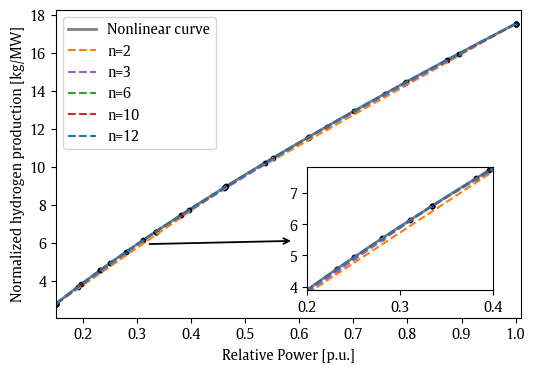

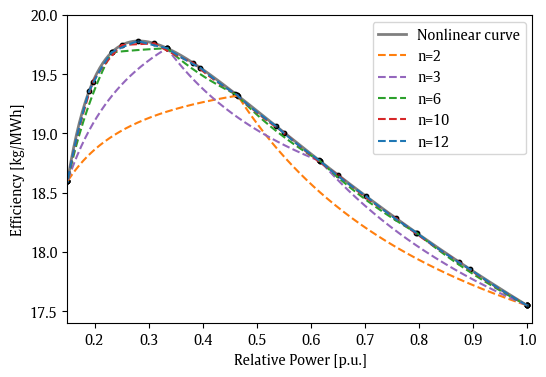

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import ConnectionPatch

# --- Assumes x_master, h_master, efficiency are already defined ---

# Define valid domain mask
mask = (x_master >= 0.15) & (x_master <= 1.0)
x_plot = x_master[mask]
h_plot = h_master[mask]
f_plot = efficiency[mask]

# --- Define fixed colors for each curve ---
colors = {
    'nonlinear': 'black',      # Nonlinear curve (solid)
    2: 'tab:orange',             # n=2
    3: 'tab:purple',           # n=3
    6: 'tab:green',            # n=6
    10: 'tab:red',             # n=10
    12: 'tab:blue'           # n=12
}

# --- Configurations of breakpoints ---
configs = [
    [0.1500, 0.4648, 1.0000],                      
    [0.1500, 0.3342, 0.6176, 1.0000],               
    [0.1500, 0.2316, 0.3342, 0.4627, 0.6176, 0.7969, 1.0000],  
    [0.1500, 0.1970, 0.2502, 0.3109, 0.3815, 0.4606, 0.5508, 0.6505, 0.7580, 0.8736, 1.0000],                    
    [0.1500, 0.1898, 0.2316, 0.2803, 0.3342, 0.3955, 0.4627, 0.5359, 0.6154, 0.7016, 0.7946, 0.8948, 1.0000]        
]

# --- Plot h(x): Normalized Hydrogen Production ---
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(x_plot, h_plot, label='Nonlinear curve', linewidth=2, color=colors['nonlinear'], alpha = 0.5)

for bp in configs:
    h_bp = np.interp(bp, x_master, h_master)
    A_segs, B_segs = [], []
    for j in range(len(bp)-1):
        x0, x1 = bp[j], bp[j+1]
        h0, h1 = h_bp[j], h_bp[j+1]
        A_segs.append((h1-h0)/(x1-x0))
        B_segs.append(h0 - A_segs[-1]*x0)
    h_approx = np.array([A_segs[min(len(bp)-2, 
                           max(0, np.searchsorted(bp, x, side='right')-1))]*x + 
                         B_segs[min(len(bp)-2, 
                           max(0, np.searchsorted(bp, x, side='right')-1))]
                        for x in x_plot])
    line, = ax.plot(x_plot, h_approx, '--', label=f'n={len(bp)-1}', color=colors[len(bp)-1])
    f_bp = np.interp(bp, x_master, h_master)
    ax.scatter(bp, f_bp, color=line.get_color(), edgecolor='k', s=10)

ax.set_xlim(0.15, 1.01)
ax.set_xlabel("Relative Power [p.u.]")
ax.set_ylabel("Normalized hydrogen production [kg/MW]")
ax.legend(loc='best')

# --- Add Zoomed Inset ---
axins = inset_axes(ax, width="40%", height="40%", loc='lower right', borderpad=2)
axins.plot(x_plot, h_plot, linewidth=2, color=colors['nonlinear'], alpha = 0.5)
for bp in configs:
    h_bp = np.interp(bp, x_master, h_master)
    A_segs, B_segs = [], []
    for j in range(len(bp)-1):
        x0, x1 = bp[j], bp[j+1]
        h0, h1 = h_bp[j], h_bp[j+1]
        A_segs.append((h1-h0)/(x1-x0))
        B_segs.append(h0 - A_segs[-1]*x0)
    h_approx = np.array([A_segs[min(len(bp)-2, 
                           max(0, np.searchsorted(bp, x, side='right')-1))]*x + 
                         B_segs[min(len(bp)-2, 
                           max(0, np.searchsorted(bp, x, side='right')-1))]
                        for x in x_plot])
    line, = axins.plot(x_plot, h_approx, '--', label=f'n={len(bp)-1}', color=colors[len(bp)-1])
    axins.scatter(bp, np.interp(bp, x_master, h_master), color=line.get_color(), edgecolor='k', s=10)

axins.set_xlim(0.2, 0.4)
axins.set_ylim(np.min(h_plot[(x_plot >= 0.2) & (x_plot <= 0.4)])*0.995,
                np.max(h_plot[(x_plot >= 0.2) & (x_plot <= 0.4)])*1.005)
axins.set_xticks([0.2, 0.3, 0.4])

# --- Add Connection Arrow ---
# Pick a zoom center
x_center = 0.31
y_center = np.interp(0.3, x_master, h_master)

# Draw connection
con = ConnectionPatch(xyA=(x_center, y_center), coordsA=ax.transData,
                      xyB=(-0.05, 0.4), coordsB=axins.transAxes,
                      arrowstyle="->", shrinkA=5, shrinkB=5, color="black", lw=1.3)
fig.add_artist(con)

plt.savefig('Normalized_hydrogen_production_linearization.pdf', bbox_inches='tight', pad_inches=0.02)
plt.show()

# --- Plot f(x): Efficiency ---
plt.figure(figsize=(6, 4))

# Nonlinear curve
plt.plot(x_plot, f_plot, label='Nonlinear curve', linewidth=2, color=colors['nonlinear'], alpha = 0.5)

for bp in configs:
    num_segments = len(bp) - 1
    h_bp = np.interp(bp, x_master, h_master)
    A_segs, B_segs = [], []
    for j in range(num_segments):
        x0, x1 = bp[j], bp[j + 1]
        h0, h1 = h_bp[j], h_bp[j + 1]
        A_segs.append((h1 - h0) / (x1 - x0))
        B_segs.append(h0 - A_segs[-1] * x0)
    # Build efficiency approximation
    f_approx = np.array([
        A_segs[min(num_segments - 1, max(0, np.searchsorted(bp, x, side='right') - 1))] +
        B_segs[min(num_segments - 1, max(0, np.searchsorted(bp, x, side='right') - 1))] / x
        for x in x_plot
    ])
    line, = plt.plot(x_plot, f_approx, '--', label=f'n={num_segments}', color=colors[num_segments])
    f_bp = np.interp(bp, x_master, efficiency)
    plt.scatter(bp, f_bp, color=line.get_color(), edgecolor='k', s=10)

plt.xlim(0.15, 1.01)
plt.ylim(17.4, 20)
plt.xlabel("Relative Power [p.u.]")
plt.ylabel("Efficiency [kg/MWh]")
plt.legend(loc='best')
plt.savefig('Efficiency_linearization.pdf', bbox_inches='tight', pad_inches=0.02)
plt.show()


# 1. Dynamic Programming 

In [37]:
import numpy as np
import matplotlib.pyplot as plt

def dynamic_programming_breakpoints(x_master, h_master, segment_list):
    # Define valid domain mask
    mask = (x_master >= 0.15) & (x_master <= 1.0)
    x_plot = x_master[mask]
    h_plot = h_master[mask]
    n = len(x_plot)

    # Precompute squared errors for all possible segments
    error_matrix = np.full((n, n), np.inf)
    for i in range(n):
        for j in range(i+1, n):
            x_seg = x_plot[i:j+1]
            h_seg = h_plot[i:j+1]
            A = np.vstack([x_seg, np.ones_like(x_seg)]).T
            m, b = np.linalg.lstsq(A, h_seg, rcond=None)[0]
            h_pred = m * x_seg + b
            mse = np.mean((h_seg - h_pred)**2)
            error_matrix[i, j] = mse

    for num_segments in segment_list:
        # Dynamic programming tables
        cost = np.full((n, num_segments+1), np.inf)
        prev = np.full((n, num_segments+1), -1)

        # Base case
        for i in range(n):
            cost[i, 1] = error_matrix[0, i]

        # Fill DP tables
        for k in range(2, num_segments+1):
            for i in range(n):
                for j in range(k-2, i):
                    if cost[j, k-1] + error_matrix[j, i] < cost[i, k]:
                        cost[i, k] = cost[j, k-1] + error_matrix[j, i]
                        prev[i, k] = j

        # Recover optimal breakpoints
        breakpoints_idx = [n-1]
        segments = num_segments
        while segments > 1:
            breakpoints_idx.append(prev[breakpoints_idx[-1], segments])
            segments -= 1

        breakpoints_idx = sorted(breakpoints_idx)
        breakpoints = x_plot[breakpoints_idx]

        # Ensure 0.15 and 1.0 are exactly included
        if breakpoints[0] != 0.15:
            breakpoints = np.insert(breakpoints, 0, 0.15)
        if breakpoints[-1] != 1.0:
            breakpoints = np.append(breakpoints, 1.0)

        # Print breakpoints
        print(f"Optimal breakpoints for {num_segments} segments:", "[" + ", ".join(f"{x:.5f}" for x in breakpoints) + "]")

dynamic_programming_breakpoints(x_master, h_master, [2, 3, 6, 10, 12])


Optimal breakpoints for 2 segments: [0.15000, 0.46476, 1.00000]
Optimal breakpoints for 3 segments: [0.15000, 0.33419, 0.61763, 1.00000]
Optimal breakpoints for 6 segments: [0.15000, 0.23165, 0.33419, 0.46270, 0.61763, 0.79688, 1.00000]
Optimal breakpoints for 10 segments: [0.15000, 0.19700, 0.25020, 0.31091, 0.38154, 0.46064, 0.55080, 0.65050, 0.75799, 0.87357, 1.00000]
Optimal breakpoints for 12 segments: [0.15000, 0.18981, 0.23165, 0.28030, 0.33419, 0.39554, 0.46270, 0.53592, 0.61545, 0.70157, 0.79458, 0.89476, 1.00000]


## 1.1. Metrics 

In [38]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

def evaluate_piecewise_metrics(x_master, h_master, efficiency, x_breakpoints):
    # Reconstruct piecewise linear h(x)
    h_breakpoints = np.interp(x_breakpoints, x_master, h_master)
    A_segments, B_segments = [], []
    num_segments = len(x_breakpoints) - 1
    for j in range(num_segments):
        x0, x1 = x_breakpoints[j], x_breakpoints[j+1]
        h0, h1 = h_breakpoints[j], h_breakpoints[j+1]
        A = (h1 - h0) / (x1 - x0)
        B = h0 - A * x0
        A_segments.append(A)
        B_segments.append(B)

    # ---- Evaluate h(x) ----
    h_approx_master = np.zeros_like(x_master)
    for idx, x in enumerate(x_master):
        if x >= 1.0:
            seg = len(x_breakpoints) - 2
        else:
            seg = np.searchsorted(x_breakpoints, x, side='right') - 1
        h_approx_master[idx] = A_segments[seg] * x + B_segments[seg]

    valid_idx = (x_master >= 0.15) & (x_master <= 1.0)
    h_true = h_master[valid_idx]
    h_pred = h_approx_master[valid_idx]
    mae_h = mean_absolute_error(h_true, h_pred)
    rmse_h = np.sqrt(mean_squared_error(h_true, h_pred))
    r2_h = r2_score(h_true, h_pred)
    with np.errstate(divide='ignore', invalid='ignore'):
        mape_h = np.mean(np.abs((h_true - h_pred) / np.where(h_true != 0, h_true, np.nan))) * 100

    # ---- Evaluate f(x) ----
    f_approx = np.zeros_like(x_master)
    for idx, x in enumerate(x_master):
        if x < 0.15:
            f_approx[idx] = 0
        elif x >= 1.0:
            seg = len(x_breakpoints) - 2
        else:
            seg = np.searchsorted(x_breakpoints, x, side='right') - 1
        f_approx[idx] = A_segments[seg] + B_segments[seg] / x

    f_true = efficiency[valid_idx]
    f_pred = f_approx[valid_idx]
    mae_f = mean_absolute_error(f_true, f_pred)
    rmse_f = np.sqrt(mean_squared_error(f_true, f_pred))
    r2_f = r2_score(f_true, f_pred)
    with np.errstate(divide='ignore', invalid='ignore'):
        mape_f = np.mean(np.abs((f_true - f_pred) / np.where(f_true != 0, f_true, np.nan))) * 100

    return {
        "breakpoints": x_breakpoints,
        "segments": num_segments,
        "mae_h": mae_h,
        "mape_h": mape_h,
        "rmse_h": rmse_h,
        "r2_h": r2_h,
        "mae_f": mae_f,
        "mape_f": mape_f,
        "rmse_f": rmse_f,
        "r2_f": r2_f
    }

# Configurations of breakpoints to compare
configs = [
    [0.1500, 0.4648, 1.0000],                      
    [0.1500, 0.3342, 0.6176, 1.0000],               
    [0.1500, 0.2316, 0.3342, 0.4627, 0.6176, 0.7969, 1.0000],  
    [0.1500, 0.1970, 0.2502, 0.3109, 0.3815, 0.4606, 0.5508, 0.6505, 0.7580, 0.8736, 1.0000],                  
    [0.1500, 0.1898, 0.2316, 0.2803, 0.3342, 0.3955, 0.4627, 0.5359, 0.6154, 0.7016, 0.7946, 0.8948, 1.0000]        
]

# 2) Evaluate each configuration
results = []
for bp in configs:
    res = evaluate_piecewise_metrics(x_master, h_master, efficiency, bp)
    # record also the number of segments
    res["num_segments"] = len(bp) - 1
    results.append(res)

# 3) Summarize in a DataFrame
df_results = pd.DataFrame(results)
df_results = df_results[[
    "num_segments",
    "mae_h", "mape_h", "rmse_h", "r2_h",
    "mae_f", "mape_f", "rmse_f", "r2_f"
]]
print(df_results)


   num_segments     mae_h    mape_h    rmse_h      r2_h     mae_f    mape_f  \
0             2  0.127358  1.535052  0.139560  0.998918  0.294585  1.535052   
1             3  0.056982  0.692091  0.062453  0.999783  0.132594  0.692091   
2             6  0.014278  0.174541  0.015652  0.999986  0.033394  0.174541   
3            10  0.005149  0.062825  0.005647  0.999998  0.012013  0.062825   
4            12  0.003572  0.043735  0.003919  0.999999  0.008362  0.043735   

     rmse_f      r2_f  
0  0.360375  0.735547  
1  0.164822  0.944681  
2  0.041987  0.996410  
3  0.015119  0.999535  
4  0.010589  0.999772  


# 2. Uniform

In [39]:
def uniform_segmentation_breakpoints(x_master, segment_list):
    """
    Generate uniformly spaced breakpoints in the domain [0.15, 1.0]
    for a list of segment counts.

    Parameters:
    - x_master: Full array of x values (used for interpolation range check)
    - segment_list: List of integers, each indicating a number of segments

    Prints:
    - Uniformly spaced breakpoints for each segment count
    """

    domain_start = 0.15
    domain_end = 1.0

    for num_segments in segment_list:
        breakpoints = np.linspace(domain_start, domain_end, num_segments + 1)

        # Optional: Ensure they fall within the actual domain of x_master
        x_min = np.min(x_master)
        x_max = np.max(x_master)
        breakpoints = np.clip(breakpoints, x_min, x_max)

        # Print formatted breakpoints
        print(f"Uniform breakpoints for {num_segments} segments:",
              "[" + ", ".join(f"{x:.5f}" for x in breakpoints) + "]")
        
uniform_segmentation_breakpoints(x_master, [2, 3, 6, 10, 12])

Uniform breakpoints for 2 segments: [0.15000, 0.57500, 1.00000]
Uniform breakpoints for 3 segments: [0.15000, 0.43333, 0.71667, 1.00000]
Uniform breakpoints for 6 segments: [0.15000, 0.29167, 0.43333, 0.57500, 0.71667, 0.85833, 1.00000]
Uniform breakpoints for 10 segments: [0.15000, 0.23500, 0.32000, 0.40500, 0.49000, 0.57500, 0.66000, 0.74500, 0.83000, 0.91500, 1.00000]
Uniform breakpoints for 12 segments: [0.15000, 0.22083, 0.29167, 0.36250, 0.43333, 0.50417, 0.57500, 0.64583, 0.71667, 0.78750, 0.85833, 0.92917, 1.00000]


## 2.1 Metrics

In [40]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

def evaluate_piecewise_metrics(x_master, h_master, efficiency, x_breakpoints):
    # Reconstruct piecewise linear h(x)
    h_breakpoints = np.interp(x_breakpoints, x_master, h_master)
    A_segments, B_segments = [], []
    num_segments = len(x_breakpoints) - 1
    for j in range(num_segments):
        x0, x1 = x_breakpoints[j], x_breakpoints[j+1]
        h0, h1 = h_breakpoints[j], h_breakpoints[j+1]
        A = (h1 - h0) / (x1 - x0)
        B = h0 - A * x0
        A_segments.append(A)
        B_segments.append(B)

    # ---- Evaluate h(x) ----
    h_approx_master = np.zeros_like(x_master)
    for idx, x in enumerate(x_master):
        if x >= 1.0:
            seg = len(x_breakpoints) - 2
        else:
            seg = np.searchsorted(x_breakpoints, x, side='right') - 1
        h_approx_master[idx] = A_segments[seg] * x + B_segments[seg]

    valid_idx = (x_master >= 0.15) & (x_master <= 1.0)
    h_true = h_master[valid_idx]
    h_pred = h_approx_master[valid_idx]
    mae_h = mean_absolute_error(h_true, h_pred)
    rmse_h = np.sqrt(mean_squared_error(h_true, h_pred))
    r2_h = r2_score(h_true, h_pred)
    with np.errstate(divide='ignore', invalid='ignore'):
        mape_h = np.mean(np.abs((h_true - h_pred) / np.where(h_true != 0, h_true, np.nan))) * 100

    # ---- Evaluate f(x) ----
    f_approx = np.zeros_like(x_master)
    for idx, x in enumerate(x_master):
        if x < 0.15:
            f_approx[idx] = 0
        elif x >= 1.0:
            seg = len(x_breakpoints) - 2
        else:
            seg = np.searchsorted(x_breakpoints, x, side='right') - 1
        f_approx[idx] = A_segments[seg] + B_segments[seg] / x

    f_true = efficiency[valid_idx]
    f_pred = f_approx[valid_idx]
    mae_f = mean_absolute_error(f_true, f_pred)
    rmse_f = np.sqrt(mean_squared_error(f_true, f_pred))
    r2_f = r2_score(f_true, f_pred)
    with np.errstate(divide='ignore', invalid='ignore'):
        mape_f = np.mean(np.abs((f_true - f_pred) / np.where(f_true != 0, f_true, np.nan))) * 100

    return {
        "breakpoints": x_breakpoints,
        "segments": num_segments,
        "mae_h": mae_h,
        "mape_h": mape_h,
        "rmse_h": rmse_h,
        "r2_h": r2_h,
        "mae_f": mae_f,
        "mape_f": mape_f,
        "rmse_f": rmse_f,
        "r2_f": r2_f
    }

# Configurations of breakpoints to compare
configs = [
    [0.15000, 0.57500, 1.00000],                     
    [0.15000, 0.43333, 0.71667, 1.00000],               
    [0.15000, 0.29167, 0.43333, 0.57500, 0.71667, 0.85833, 1.00000],  
    [0.15000, 0.23500, 0.32000, 0.40500, 0.49000, 0.57500, 0.66000, 0.74500, 0.83000, 0.91500, 1.00000],                   
    [0.15000, 0.22083, 0.29167, 0.36250, 0.43333, 0.50417, 0.57500, 0.64583, 0.71667, 0.78750, 0.85833, 0.92917, 1.00000]        
]

# 2) Evaluate each configuration
results = []
for bp in configs:
    res = evaluate_piecewise_metrics(x_master, h_master, efficiency, bp)
    # record also the number of segments
    res["num_segments"] = len(bp) - 1
    results.append(res)

# 3) Summarize in a DataFrame
df_results = pd.DataFrame(results)
df_results = df_results[[
    "num_segments",
    "mae_h", "mape_h", "rmse_h", "r2_h",
    "mae_f", "mape_f", "rmse_f", "r2_f"
]]
print(df_results)


   num_segments     mae_h    mape_h    rmse_h      r2_h     mae_f    mape_f  \
0             2  0.139579  1.937485  0.167325  0.998445  0.376059  1.937485   
1             3  0.064611  0.973199  0.080974  0.999636  0.189087  0.973199   
2             6  0.016628  0.271773  0.021786  0.999974  0.052659  0.271773   
3            10  0.006021  0.100843  0.007974  0.999996  0.019496  0.100843   
4            12  0.004184  0.070383  0.005551  0.999998  0.013600  0.070383   

     rmse_f      r2_f  
0  0.510257  0.469828  
1  0.282830  0.837112  
2  0.088823  0.983934  
3  0.034323  0.997601  
4  0.024142  0.998813  


# 3. Greedy descent segmentation

In [41]:
def greedy_segmentation_breakpoints(x_master, h_master, segment_list):
    """
    Generate breakpoints using greedy descent method to minimize MSE
    between h_master and linear piecewise approximation of h(x).
    """

    def local_error(x_vals, h_vals, x0, x1):
        mask = (x_vals >= x0) & (x_vals <= x1)
        x_seg = x_vals[mask]
        h_seg = h_vals[mask]
        if len(x_seg) < 2:
            return 0, None  # Can't fit a line
        A = np.vstack([x_seg, np.ones_like(x_seg)]).T
        m, b = np.linalg.lstsq(A, h_seg, rcond=None)[0]
        h_pred = m * x_seg + b
        mse = np.mean((h_seg - h_pred) ** 2)
        return mse, None

    def best_split_point(x_vals, h_vals, x0, x1):
        candidates = x_vals[(x_vals > x0) & (x_vals < x1)]
        best_mse = float('inf')
        best_x = None
        for x in candidates:
            mse1, _ = local_error(x_vals, h_vals, x0, x)
            mse2, _ = local_error(x_vals, h_vals, x, x1)
            mse_total = mse1 + mse2
            if mse_total < best_mse:
                best_mse = mse_total
                best_x = x
        return best_x

    domain_mask = (x_master >= 0.15) & (x_master <= 1.0)
    x_vals = x_master[domain_mask]
    h_vals = h_master[domain_mask]

    for n_segments in segment_list:
        breakpoints = [0.15, 1.0]
        while len(breakpoints) < n_segments + 1:
            # Identify segment with highest error
            max_error = -1
            best_segment = None
            for i in range(len(breakpoints) - 1):
                x0 = breakpoints[i]
                x1 = breakpoints[i + 1]
                mse, _ = local_error(x_vals, h_vals, x0, x1)
                if mse > max_error:
                    max_error = mse
                    best_segment = (x0, x1)

            # Insert best new point
            x_new = best_split_point(x_vals, h_vals, best_segment[0], best_segment[1])
            if x_new is None or x_new in breakpoints:
                break  # No valid new point
            breakpoints.append(x_new)
            breakpoints = sorted(breakpoints)

        # Print result
        print(f"Greedy breakpoints for {n_segments} segments:",
              "[" + ", ".join(f"{x:.5f}" for x in breakpoints) + "]")

greedy_segmentation_breakpoints(x_master, h_master, [2, 3, 6, 10, 12])


Greedy breakpoints for 2 segments: [0.15000, 0.46476, 1.00000]
Greedy breakpoints for 3 segments: [0.15000, 0.28030, 0.46476, 1.00000]
Greedy breakpoints for 6 segments: [0.15000, 0.20967, 0.28030, 0.36564, 0.46476, 0.70605, 1.00000]
Greedy breakpoints for 10 segments: [0.15000, 0.20967, 0.24275, 0.28030, 0.32058, 0.36564, 0.46476, 0.57864, 0.70605, 0.84550, 1.00000]
Greedy breakpoints for 12 segments: [0.15000, 0.20967, 0.24275, 0.28030, 0.32058, 0.36564, 0.41367, 0.46476, 0.51900, 0.57864, 0.70605, 0.84550, 1.00000]


## 3.1 Metrics

In [42]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

def evaluate_piecewise_metrics(x_master, h_master, efficiency, x_breakpoints):
    # Reconstruct piecewise linear h(x)
    h_breakpoints = np.interp(x_breakpoints, x_master, h_master)
    A_segments, B_segments = [], []
    num_segments = len(x_breakpoints) - 1
    for j in range(num_segments):
        x0, x1 = x_breakpoints[j], x_breakpoints[j+1]
        h0, h1 = h_breakpoints[j], h_breakpoints[j+1]
        A = (h1 - h0) / (x1 - x0)
        B = h0 - A * x0
        A_segments.append(A)
        B_segments.append(B)

    # ---- Evaluate h(x) ----
    h_approx_master = np.zeros_like(x_master)
    for idx, x in enumerate(x_master):
        if x >= 1.0:
            seg = len(x_breakpoints) - 2
        else:
            seg = np.searchsorted(x_breakpoints, x, side='right') - 1
        h_approx_master[idx] = A_segments[seg] * x + B_segments[seg]

    valid_idx = (x_master >= 0.15) & (x_master <= 1.0)
    h_true = h_master[valid_idx]
    h_pred = h_approx_master[valid_idx]
    mae_h = mean_absolute_error(h_true, h_pred)
    rmse_h = np.sqrt(mean_squared_error(h_true, h_pred))
    r2_h = r2_score(h_true, h_pred)
    with np.errstate(divide='ignore', invalid='ignore'):
        mape_h = np.mean(np.abs((h_true - h_pred) / np.where(h_true != 0, h_true, np.nan))) * 100

    # ---- Evaluate f(x) ----
    f_approx = np.zeros_like(x_master)
    for idx, x in enumerate(x_master):
        if x < 0.15:
            f_approx[idx] = 0
        elif x >= 1.0:
            seg = len(x_breakpoints) - 2
        else:
            seg = np.searchsorted(x_breakpoints, x, side='right') - 1
        f_approx[idx] = A_segments[seg] + B_segments[seg] / x

    f_true = efficiency[valid_idx]
    f_pred = f_approx[valid_idx]
    mae_f = mean_absolute_error(f_true, f_pred)
    rmse_f = np.sqrt(mean_squared_error(f_true, f_pred))
    r2_f = r2_score(f_true, f_pred)
    with np.errstate(divide='ignore', invalid='ignore'):
        mape_f = np.mean(np.abs((f_true - f_pred) / np.where(f_true != 0, f_true, np.nan))) * 100

    return {
        "breakpoints": x_breakpoints,
        "segments": num_segments,
        "mae_h": mae_h,
        "mape_h": mape_h,
        "rmse_h": rmse_h,
        "r2_h": r2_h,
        "mae_f": mae_f,
        "mape_f": mape_f,
        "rmse_f": rmse_f,
        "r2_f": r2_f
    }

# Configurations of breakpoints to compare
configs = [
    [0.15000, 0.57500, 1.00000],                     
    [0.15000, 0.43333, 0.71667, 1.00000],               
    [0.15000, 0.29167, 0.43333, 0.57500, 0.71667, 0.85833, 1.00000],  
    [0.15000, 0.23500, 0.32000, 0.40500, 0.49000, 0.57500, 0.66000, 0.74500, 0.83000, 0.91500, 1.00000],                   
    [0.15000, 0.18981, 0.23165, 0.28030, 0.33419, 0.39554, 0.46270, 0.53592, 0.61545, 0.70157, 0.79458, 0.89476, 1.00000],
    [0.15000, 0.22083, 0.29167, 0.36250, 0.43333, 0.50417, 0.57500, 0.64583, 0.71667, 0.78750, 0.85833, 0.92917, 1.00000],
    [0.15000, 0.20967, 0.24275, 0.28030, 0.32058, 0.36564, 0.41367, 0.46476, 0.51900, 0.57864, 0.70605, 0.84550, 1.00000]
]

# 2) Evaluate each configuration
results = []
for bp in configs:
    res = evaluate_piecewise_metrics(x_master, h_master, efficiency, bp)
    # record also the number of segments
    res["num_segments"] = len(bp) - 1
    results.append(res)

# 3) Summarize in a DataFrame
df_results = pd.DataFrame(results)
df_results = df_results[[
    "num_segments",
    "mae_h", "mape_h", "rmse_h", "r2_h",
    "mae_f", "mape_f", "rmse_f", "r2_f"
]]
print(df_results)


   num_segments     mae_h    mape_h    rmse_h      r2_h     mae_f    mape_f  \
0             2  0.139579  1.937485  0.167325  0.998445  0.376059  1.937485   
1             3  0.064611  0.973199  0.080974  0.999636  0.189087  0.973199   
2             6  0.016628  0.271773  0.021786  0.999974  0.052659  0.271773   
3            10  0.006021  0.100843  0.007974  0.999996  0.019496  0.100843   
4            12  0.003572  0.043732  0.003919  0.999999  0.008361  0.043732   
5            12  0.004184  0.070383  0.005551  0.999998  0.013600  0.070383   
6            12  0.005221  0.058565  0.006572  0.999998  0.011040  0.058565   

     rmse_f      r2_f  
0  0.510257  0.469828  
1  0.282830  0.837112  
2  0.088823  0.983934  
3  0.034323  0.997601  
4  0.010589  0.999772  
5  0.024142  0.998813  
6  0.016684  0.999433  


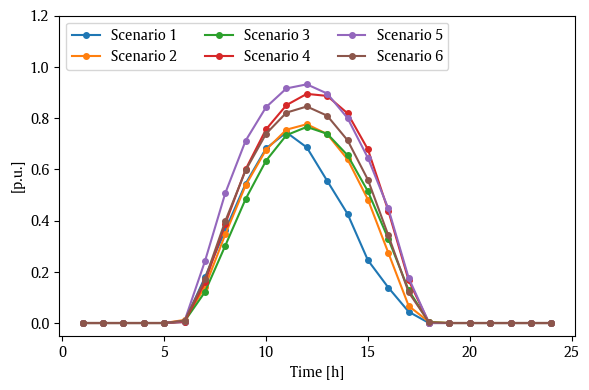

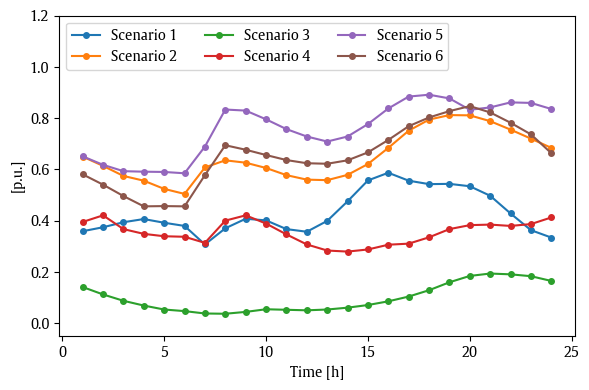

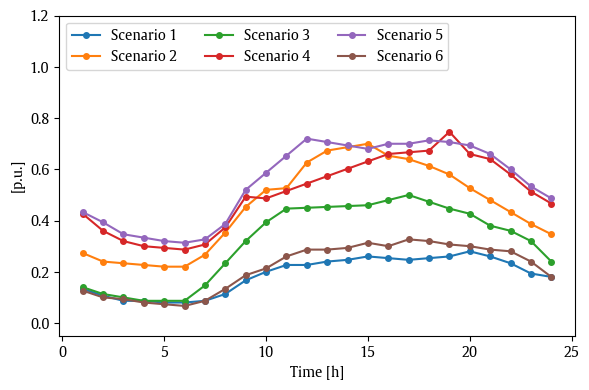

In [43]:
import pandas as pd
import matplotlib.pyplot as plt

# Load CSVs again, assuming the index should be 1 to 24 (hours), and columns are the 5 types
df_fPV = pd.read_csv('pv_representative_ninja24_all.csv', index_col=0).T
df_fWT = pd.read_csv('wind_representative_ninja24_all.csv', index_col=0).T
df_PD  = pd.read_csv('demand_representative_ninja24_all.csv', index_col=0).T

# Fix index to represent hour of day (1 to 24)
df_fPV.index = range(1, 25)
df_fWT.index = range(1, 25)
df_PD.index = range(1, 25)

# Plotting function
def plot_profiles(df, title):
    plt.figure(figsize=(6, 4))
    for col in df.columns:
        plt.plot(df.index, df[col], marker='o', label=f'Scenario {col+1}', markersize=4)  # Reduced marker size
    plt.xlabel("Time [h]")
    plt.ylabel("[p.u.]")
    plt.ylim(-0.05, 1.2)
    plt.legend(loc='upper left', ncol=3)    

    plt.tight_layout()
    plt.savefig(f"{title.replace(' ', '_')}.pdf", bbox_inches='tight', pad_inches=0.02)
    plt.show()

# Generate plots
plot_profiles(df_fPV, "PV Generation Profiles")
plot_profiles(df_fWT, "Wind Generation Profiles")
plot_profiles(df_PD, "Demand Profiles")


C:\Users\loroya13\AppData\Local\Temp\ipykernel_6892\4023877076.py:22: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot=soc_percent.round(0).astype(int).applymap(lambda x: f"{x}%"), fmt="",


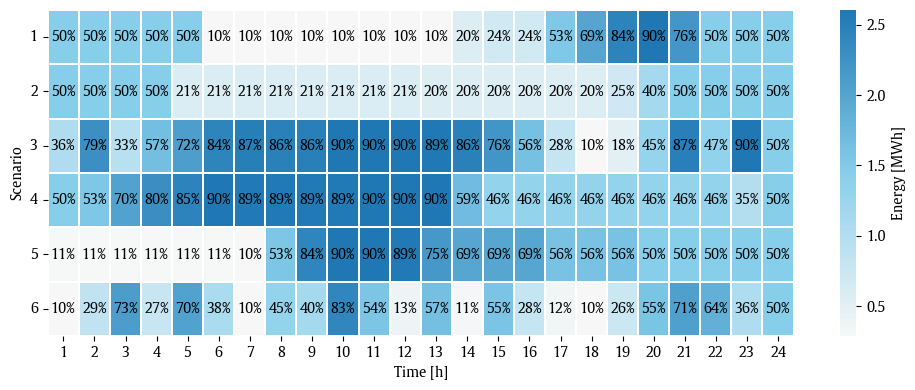

In [232]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Load and pivot
df = pd.read_csv("EBESS_master.csv")
pivot_df = df.pivot(index='scenario', columns='hour', values='value')

# Define EBESS maximum capacity [MWh]
EBESSmax =   2.89245 # replace with your actual value

# Compute SoC [%]
soc_percent = (pivot_df / EBESSmax) * 100

colors = ["#f7f7f7", "skyblue" ,"#1f78b4"]  # light → medium blue → green
custom_cmap = LinearSegmentedColormap.from_list("custom", colors)

# Plot
plt.figure(figsize=(10, 4))
sns.heatmap(pivot_df, cmap=custom_cmap, 
            annot=soc_percent.round(0).astype(int).applymap(lambda x: f"{x}%"), fmt="", 
            cbar_kws={'label': 'Energy [MWh]'}, linewidths=0.3, 
            annot_kws={"size": 10, "color": "black"})

plt.xlabel("Time [h]")
plt.ylabel("Scenario")
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("SOC_scenarios.pdf", bbox_inches='tight', pad_inches=0.02)
plt.show()


C:\Users\loroya13\AppData\Local\Temp\ipykernel_6892\4281371303.py:22: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot=soc_percent.round(0).astype(int).applymap(lambda x: f"{x}%"), fmt="",


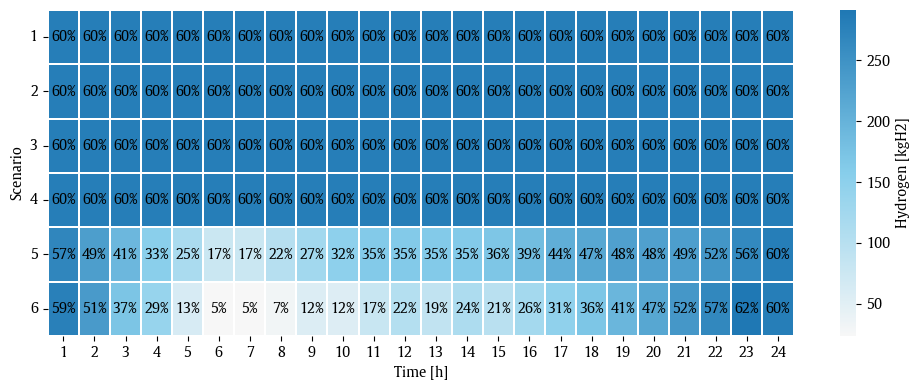

In [233]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Load and pivot
df = pd.read_csv("mHST_master.csv")
pivot_df = df.pivot(index='scenario', columns='hour', values='value')

# Define EBESS maximum capacity [MWh]
HSTmax = 469.623 # replace with your actual value

# Compute SoC [%]
soc_percent = (pivot_df / HSTmax) * 100

colors = ["#f7f7f7", "skyblue" ,"#1f78b4"]  # light → medium blue → green
custom_cmap = LinearSegmentedColormap.from_list("custom", colors)

# Plot
plt.figure(figsize=(10, 4))
sns.heatmap(pivot_df, cmap=custom_cmap, 
            annot=soc_percent.round(0).astype(int).applymap(lambda x: f"{x}%"), fmt="", 
            cbar_kws={'label': 'Hydrogen [kgH2]'}, linewidths=0.3, 
            annot_kws={"size": 10, "color": "black"})

plt.xlabel("Time [h]")
plt.ylabel("Scenario")
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("HST_scenarios.pdf", bbox_inches='tight', pad_inches=0.02)
plt.show()


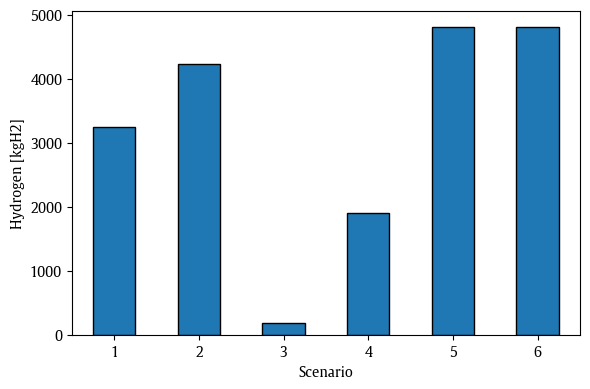

In [237]:
import pandas as pd
import matplotlib.pyplot as plt

# Load and pivot
df = pd.read_csv("H2_prod_master.csv")
pivot_df = df.pivot(index='hour', columns='scenario', values='value')

# Calculate total hydrogen per scenario
total_h2_per_scenario = pivot_df.sum(axis=0)

# Bar plot
plt.figure(figsize=(6, 4))
total_h2_per_scenario.plot(kind='bar', color = "#1f78b4" , edgecolor='black')

plt.xlabel("Scenario")
plt.ylabel("Hydrogen [kgH2]")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


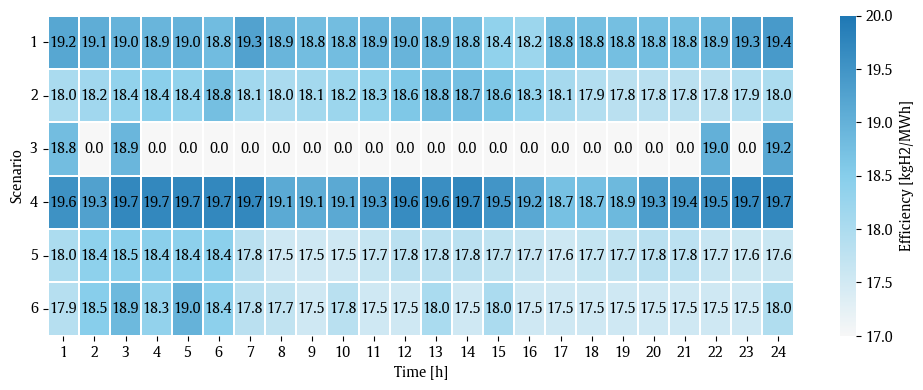

In [235]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Load and pivot
df_h2 = pd.read_csv("H2_prod_master.csv")
df_power = pd.read_csv("PEL_master.csv")

pivot_h2 = df_h2.pivot(index='scenario', columns='hour', values='value')
pivot_power = df_power.pivot(index='scenario', columns='hour', values='value')

# Compute efficiency [kgH2/MWh]
efficiency = pivot_h2 / pivot_power
efficiency = efficiency.replace([float('inf'), -float('inf')], pd.NA).fillna(0)

colors = ["#f7f7f7", "skyblue" ,"#1f78b4"]  # light → medium blue → green
custom_cmap = LinearSegmentedColormap.from_list("custom", colors)

# Plot
plt.figure(figsize=(10, 4))
sns.heatmap(
    efficiency,
    cmap=custom_cmap,  # or your custom colormap
    vmin=17, vmax=20,  # adjust this range based on your data
    annot=efficiency.round(1).astype(str),
    fmt="",
    cbar_kws={'label': 'Efficiency [kgH2/MWh]'},
    linewidths=0.3,
    annot_kws={"size": 10, "color": "black"}
)


plt.xlabel("Time [h]")
plt.ylabel("Scenario")
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("Efficiency_scenarios.pdf", bbox_inches='tight', pad_inches=0.02)
plt.show()


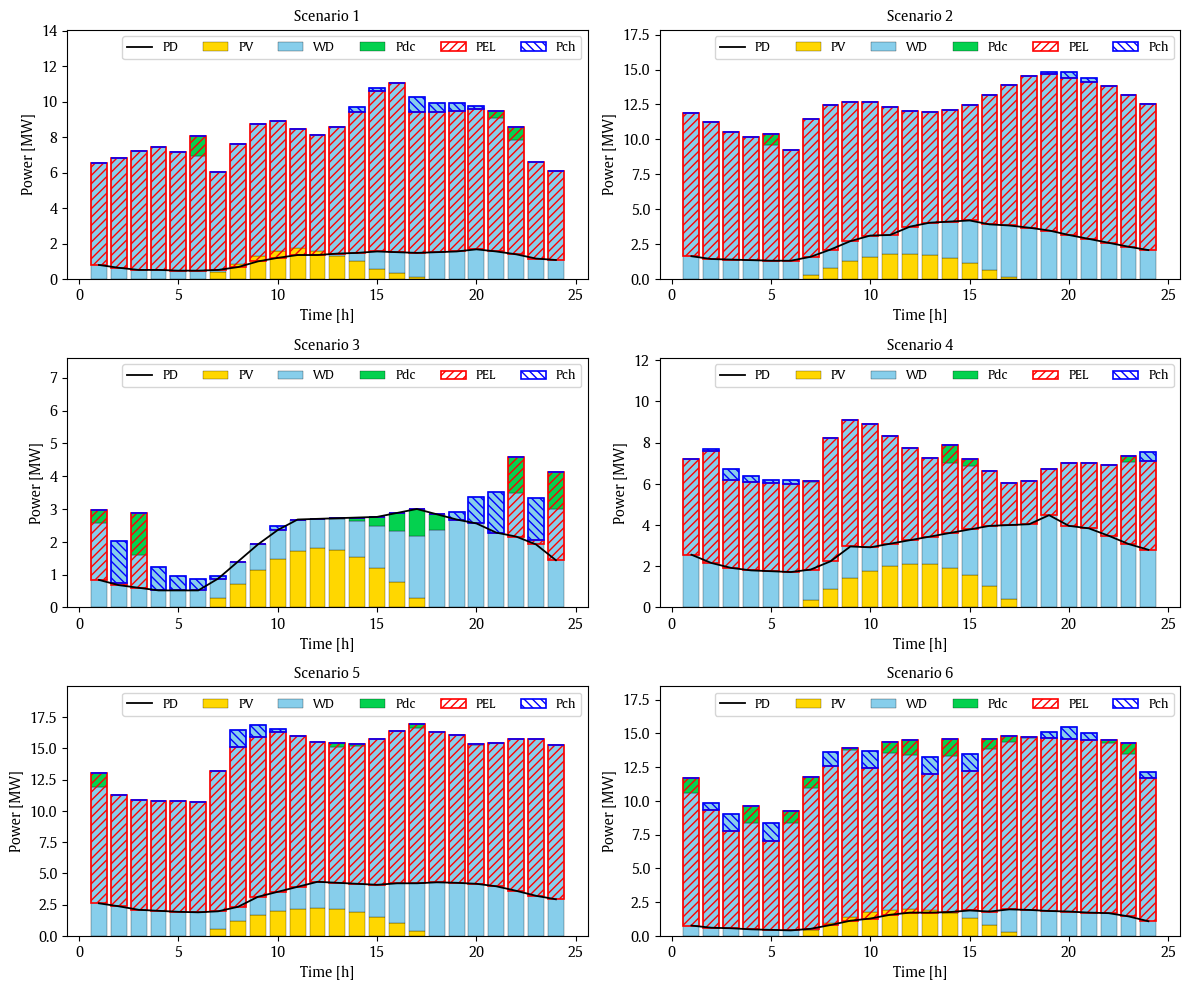

In [265]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df_pv = pd.read_csv("fPV.csv")
df_wt = pd.read_csv("fWT.csv")
df_demand = pd.read_csv("PD.csv")
df_h2_demand = pd.read_csv("PEL_master.csv")
df_bess = pd.read_csv("PBESSd_master.csv")         # Discharge
df_bess_charge = pd.read_csv("PBESSc_master.csv")  # Charge

# Pivot
pv_pivot = df_pv.pivot(index='hour', columns='scenario', values='value')
wt_pivot = df_wt.pivot(index='hour', columns='scenario', values='value')
demand_pivot = df_demand.pivot(index='hour', columns='scenario', values='value')
h2_pivot = df_h2_demand.pivot(index='hour', columns='scenario', values='value')
bess_pivot = df_bess.pivot(index='hour', columns='scenario', values='value')
bess_charge_pivot = df_bess_charge.pivot(index='hour', columns='scenario', values='value')

# Align all
pv_pivot, wt_pivot = pv_pivot.align(wt_pivot, join='inner', axis=0)
pv_pivot, demand_pivot = pv_pivot.align(demand_pivot, join='inner', axis=0)
pv_pivot, h2_pivot = pv_pivot.align(h2_pivot, join='inner', axis=0)
pv_pivot, bess_pivot = pv_pivot.align(bess_pivot, join='inner', axis=0)
pv_pivot, bess_charge_pivot = pv_pivot.align(bess_charge_pivot, join='inner', axis=0)

# Subplots in 3x2 grid
n = len(pv_pivot.columns)
nrows, ncols = 3, 2
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 10))

axs = axs.flatten()  # flatten to index easily

for i, scenario in enumerate(pv_pivot.columns):
    ax = axs[i]
    hours = pv_pivot.index

    pv = pv_pivot[scenario]
    wt = wt_pivot[scenario]
    bess = bess_pivot[scenario]
    bess_charging = bess_charge_pivot[scenario]
    base_demand = demand_pivot[scenario]
    h2_demand = h2_pivot[scenario]
    total_demand = base_demand + h2_demand

    # --- Generation bars ---
    ax.bar(hours, pv, label="PV", color='gold', edgecolor='black', linewidth=0.2)
    ax.bar(hours, wt, bottom=pv, label="WD", color='skyblue', edgecolor='black', linewidth=0.2)
    ax.bar(hours, bess, bottom=pv + wt, label="Pdc", color='#04d14f', edgecolor='black', linewidth=0.2)
    
    # --- Demand components ---
    ax.plot(hours, base_demand, label="PD", color='black', linewidth=1.3)
    
    ax.bar(hours, h2_demand, bottom=base_demand, label="PEL", 
           color='none', edgecolor='red', hatch='////', linewidth=1.2)

    ax.bar(hours, bess_charging, bottom=base_demand + h2_demand, label="Pch", 
           color='none', edgecolor='blue', hatch='\\\\\\\\', linewidth=1.2)

    y_max = max((pv + wt + bess).max(), (base_demand + h2_demand + bess_charging).max())
    ax.set_ylim(0, y_max + 3)

    ax.set_ylabel("Power [MW]")
    ax.set_title(f"Scenario {scenario}")
    ax.set_xlabel("Time [h]")
    ax.legend(loc="upper right", fontsize=9, ncol=6)

# Hide unused axes if there are fewer than 6 scenarios
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()
